In [4]:
%%bash
cd ~/data
rm -rf jena_climate
mkdir jena_climate
cd jena_climate
wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip unzip jena_climate_2009_2016.csv.zip
unzip jena_climate_2009_2016.csv.zip

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  


--2018-10-09 19:54:19--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.136.85
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.136.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13568290 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

     0K .......... .......... .......... .......... ..........  0% 1.23M 10s
    50K .......... .......... .......... .......... ..........  0% 1.85M 9s
   100K .......... .......... .......... .......... ..........  1% 3.67M 7s
   150K .......... .......... .......... .......... ..........  1% 1.85M 7s
   200K .......... .......... .......... .......... ..........  1% 3.68M 6s
   250K .......... .......... .......... .......... ..........  2% 3.65M 6s
   300K .......... .......... .......... .......... ..........  2% 3.70M 5s
   350K .......... .......... .......... .......... ..........  3% 3.69M 5s
   400K ........

In [6]:
import os
data_dir = os.path.expanduser('~/data/jena_climate')
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')
f = open(fname)
data = f.read()
f.close()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [10]:
import matplotlib.pyplot as plt

In [7]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [8]:
float_data.shape

(420551, 14)

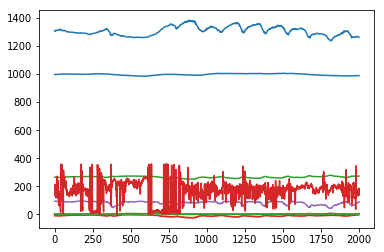

In [13]:
_  = plt.plot(float_data[:2000, :])

In [14]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

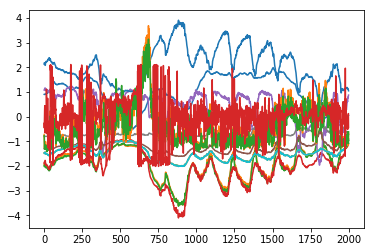

In [15]:
_  = plt.plot(float_data[:2000, :])

In [16]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):

    if max_index is None:
        max_index = len(data) - delay - 1

    i = min_index + lookback

    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback

            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))

        targets = np.zeros((len(rows),))

        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]

        yield samples, targets

In [17]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

In [34]:
train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

In [19]:
val_steps = (300000 - 200001 - lookback)
test_steps = (len(float_data) - 300001 - lookback)

In [28]:
batch = next(train_gen)
samples_batch, targets_batch = batch

In [29]:
samples_batch.shape, targets_batch.shape

((128, 240, 14), (128,))

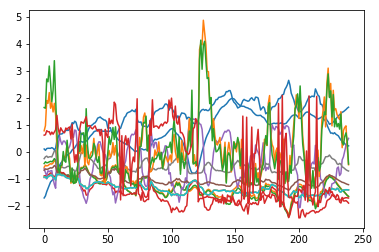

In [31]:
_ = plt.plot(samples_batch[0])

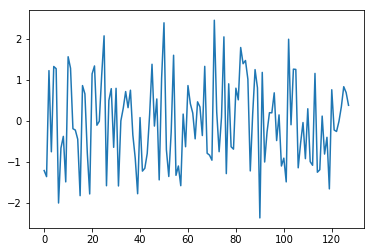

In [33]:
_ = plt.plot(targets_batch)

In [35]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)


Using TensorFlow backend.


Epoch 1/40
499/500 [============================>.] - ETA: 0s - loss: 0.3379

KeyboardInterrupt: 

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()